In [6]:
import sys
import os

# 获取顶层目录的路径
top_level_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(top_level_path)
# 将顶层目录添加到 Python 的路径中
if top_level_path not in sys.path:
    sys.path.append(top_level_path)

/home/gpt/grm/CLISA_Hydra


In [7]:
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf
import numpy as np
import os
from data.dataset import PDataset
from model.pl_models import MLPModel
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torch
import logging
import glob
from utils.utils import config_logging, get_confusionMat



In [8]:
with initialize(version_base="1.3", config_path="../cfgs"):
    # cfg = compose(config_name="config", overrides=['log.run=47','data=FACED_def', 'train.iftest=False', 'log.exp_name=nodilation',
    #                                                'mlp.wd=0.0022', 'train.gpus=[5]', 'train.valid_method=10'])
    # cfg = compose(config_name="config", overrides=['log.run=56','data=FACED_def', 'train.iftest=False', 'log.exp_name=use_pretrainFalse',
    #                                                'mlp.wd=0.0075', 'train.gpus=[3]', 'train.valid_method=10'])
    cfg = compose(config_name="config", overrides=['log.run=57','data=SEEDV', 'train.iftest=False', 'log.exp_name=use_pretrainFalse',
                                                   'mlp.wd=0.0022', 'train.gpus=[3]', 'train.valid_method="loo"'])
    print(OmegaConf.to_yaml(cfg))
    cfg = DictConfig(cfg)
    

seed: 7
log:
  run: 57
  proj_name: CLISA_FACED_new
  exp_name: use_pretrainFalse
  cp_dir: /mnt/data/model_weights/grm/clisa_cp2/
train:
  gpus:
  - 3
  valid_method: loo
  iftest: false
  n_subs: ${data.n_subs}
  lr: 0.0007
  wd: 0.00015
  loss_temp: 0.07
  max_epochs: 30
  min_epochs: 10
  patience: 30
  num_workers: 8
  restart_times: ${train.max_epochs}
mlp:
  hidden_dim: 128
  out_dim: ${data.n_class}
  lr: 0.0005
  wd: 0.0022
  max_epochs: 100
  min_epochs: 30
  patience: 30
  gpus: ${train.gpus}
  num_workers: ${train.num_workers}
  batch_size: 256
ext_fea:
  normTrain: true
  batch_size: 256
  mode: me
  rn_decay: 0.99
  use_pretrain: true
data:
  dataset_name: SEEDV
  data_dir: /mnt/data/model_weights/grm/SEEDV_new2
  fs: 125
  n_channs: 60
  n_session: 3
  n_subs: 16
  n_vids: 15
  n_class: 5
  timeLen: 22
  timeStep: 11
  timeLen2: 1
  timeStep2: 1
  class_names:
  - Disgust
  - Fear
  - Sad
  - Neutral
  - Happy
model:
  _target_: model.models.Conv_att_simple_new
  n_timeF

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_mat, class_names, mode='recall'):
    if mode == 'recall':
        confusion_mat = confusion_mat / confusion_mat.sum(axis=0, keepdims=True)
    elif mode == 'precision':
        confusion_mat = confusion_mat / confusion_mat.sum(axis=1, keepdims=True)
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)  # 调整字体大小
    # sns.heatmap(confusion_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')
    ax = sns.heatmap(confusion_mat, annot=True, annot_kws={"size": 16}, 
                     fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    ax.set_aspect('equal')  # 确保每个方格为正方形
    plt.xticks(rotation=45)  # 标签旋转45度
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.title('Confusion Matrix')
    plt.show()



def mat_statistics(confusion_mat):
    correct_predictions  = np.trace(confusion_mat)
    total_samples  = confusion_mat.sum()
    accuracy = correct_predictions / total_samples 
    recall = np.diag(confusion_mat) / confusion_mat.sum(axis=0)
    precision = np.diag(confusion_mat) / confusion_mat.sum(axis=1)

    precision_mean = np.mean(precision)
    recall_mean = np.mean(recall)
    f1 = 2 * precision_mean * recall_mean / (precision_mean + recall_mean)
    
    print('accuracy:', accuracy)
    print('precision mean(balanced acc):', precision_mean)
    print('recall mean:', recall_mean)
    print('f1', f1)
    
    return accuracy, precision_mean, recall_mean, f1
    

Global seed set to 7


2024-06-27 23:11:16: [INFO]: fold:0
2024-06-27 23:11:16: [INFO]: train_subs:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2024-06-27 23:11:16: [INFO]: val_subs:[0]


2024-06-27 23:11:16: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f0_fea_me.npy
2024-06-27 23:11:16: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:17: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f0_use_pretrainFalse_mlp_r57_f0_best_wd0.0022.ckpt
2024-06-27 23:11:17: [WARNING]: /home/gpt/anaconda3/envs/torch2/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(

2024-06-27 23:11:17: [WARNING]: /home/gpt/anaconda3/envs/torch2/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python c

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:17: [INFO]: fold:1
2024-06-27 23:11:17: [INFO]: train_subs:[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2024-06-27 23:11:17: [INFO]: val_subs:[1]
2024-06-27 23:11:17: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f1_fea_me.npy
2024-06-27 23:11:17: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:17: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f11_use_pretrainFalse_mlp_r57_f11_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:18: [INFO]: fold:2
2024-06-27 23:11:18: [INFO]: train_subs:[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2024-06-27 23:11:18: [INFO]: val_subs:[2]
2024-06-27 23:11:18: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f2_fea_me.npy
2024-06-27 23:11:18: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:18: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f2_use_pretrainFalse_mlp_r57_f2_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:19: [INFO]: fold:3
2024-06-27 23:11:19: [INFO]: train_subs:[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2024-06-27 23:11:19: [INFO]: val_subs:[3]
2024-06-27 23:11:19: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f3_fea_me.npy
2024-06-27 23:11:19: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:19: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f3_use_pretrainFalse_mlp_r57_f3_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:19: [INFO]: fold:4
2024-06-27 23:11:19: [INFO]: train_subs:[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2024-06-27 23:11:19: [INFO]: val_subs:[4]
2024-06-27 23:11:19: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f4_fea_me.npy
2024-06-27 23:11:19: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:19: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f4_use_pretrainFalse_mlp_r57_f4_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:20: [INFO]: fold:5
2024-06-27 23:11:20: [INFO]: train_subs:[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2024-06-27 23:11:20: [INFO]: val_subs:[5]
2024-06-27 23:11:20: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f5_fea_me.npy
2024-06-27 23:11:20: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:20: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f5_use_pretrainFalse_mlp_r57_f5_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:21: [INFO]: fold:6
2024-06-27 23:11:21: [INFO]: train_subs:[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]
2024-06-27 23:11:21: [INFO]: val_subs:[6]
2024-06-27 23:11:21: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f6_fea_me.npy
2024-06-27 23:11:21: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:21: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f6_use_pretrainFalse_mlp_r57_f6_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:22: [INFO]: fold:7
2024-06-27 23:11:22: [INFO]: train_subs:[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
2024-06-27 23:11:22: [INFO]: val_subs:[7]
2024-06-27 23:11:22: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f7_fea_me.npy
2024-06-27 23:11:22: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:22: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f7_use_pretrainFalse_mlp_r57_f7_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:22: [INFO]: fold:8
2024-06-27 23:11:22: [INFO]: train_subs:[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]
2024-06-27 23:11:22: [INFO]: val_subs:[8]
2024-06-27 23:11:22: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f8_fea_me.npy
2024-06-27 23:11:22: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:22: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f8_use_pretrainFalse_mlp_r57_f8_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:23: [INFO]: fold:9
2024-06-27 23:11:23: [INFO]: train_subs:[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]
2024-06-27 23:11:23: [INFO]: val_subs:[9]
2024-06-27 23:11:24: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f9_fea_me.npy
2024-06-27 23:11:24: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:24: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f9_use_pretrainFalse_mlp_r57_f9_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:24: [INFO]: fold:10
2024-06-27 23:11:24: [INFO]: train_subs:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15]
2024-06-27 23:11:24: [INFO]: val_subs:[10]
2024-06-27 23:11:25: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f10_fea_me.npy
2024-06-27 23:11:25: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:25: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f10_use_pretrainFalse_mlp_r57_f10_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:25: [INFO]: fold:11
2024-06-27 23:11:25: [INFO]: train_subs:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15]
2024-06-27 23:11:25: [INFO]: val_subs:[11]
2024-06-27 23:11:26: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f11_fea_me.npy
2024-06-27 23:11:26: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:26: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f11_use_pretrainFalse_mlp_r57_f11_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:27: [INFO]: fold:12
2024-06-27 23:11:27: [INFO]: train_subs:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15]
2024-06-27 23:11:27: [INFO]: val_subs:[12]
2024-06-27 23:11:27: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f12_fea_me.npy
2024-06-27 23:11:27: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:27: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f12_use_pretrainFalse_mlp_r57_f12_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:28: [INFO]: fold:13
2024-06-27 23:11:28: [INFO]: train_subs:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
2024-06-27 23:11:28: [INFO]: val_subs:[13]
2024-06-27 23:11:28: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f13_fea_me.npy
2024-06-27 23:11:28: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:28: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f13_use_pretrainFalse_mlp_r57_f13_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:29: [INFO]: fold:14
2024-06-27 23:11:29: [INFO]: train_subs:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
2024-06-27 23:11:29: [INFO]: val_subs:[14]
2024-06-27 23:11:29: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f14_fea_me.npy
2024-06-27 23:11:29: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:29: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f14_use_pretrainFalse_mlp_r57_f14_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

2024-06-27 23:11:30: [INFO]: fold:15
2024-06-27 23:11:30: [INFO]: train_subs:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
2024-06-27 23:11:30: [INFO]: val_subs:[15]
2024-06-27 23:11:31: [INFO]: data2 load from: /mnt/data/model_weights/grm/SEEDV_new2/ext_fea/fea_r57/use_pretrainFalse_r57_f15_fea_me.npy
2024-06-27 23:11:31: [INFO]: data2 shape: (16, 7359, 300)
2024-06-27 23:11:31: [INFO]: checkpoint load from: /mnt/data/model_weights/grm/clisa_cp2/SEEDV/r57/mlp_f15_use_pretrainFalse_mlp_r57_f15_best_wd0.0022.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

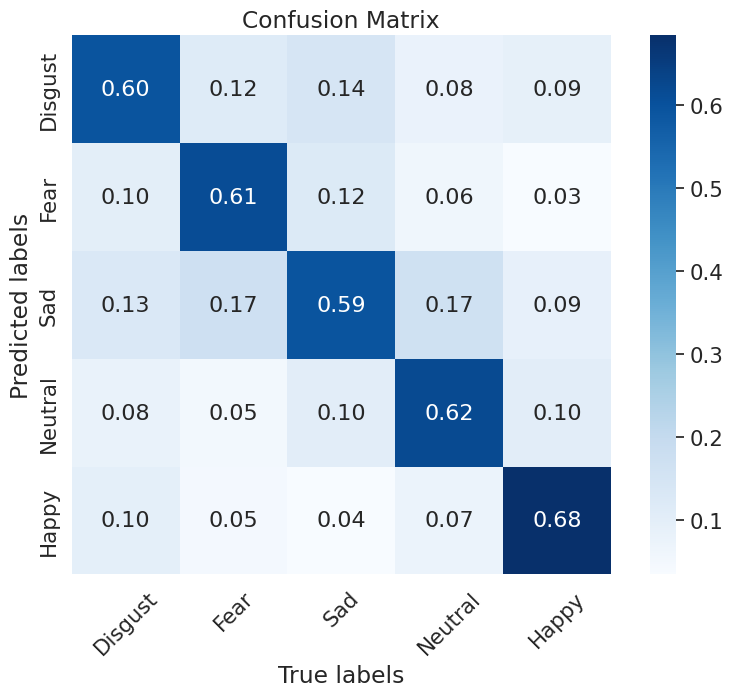

accuracy: 0.6182565565973638
precision mean(balanced acc): 0.6219792348763347
recall mean: 0.6213023650287477
f1 0.6216406157011252


(0.6182565565973638,
 0.6219792348763347,
 0.6213023650287477,
 0.6216406157011252)

In [10]:
log = logging.getLogger(__name__)
config_logging(__name__,logging.INFO)


def train_mlp(cfg: DictConfig) -> None:
    
    pl.seed_everything(cfg.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    if isinstance(cfg.train.valid_method, int):
        n_folds = cfg.train.valid_method
    elif cfg.train.valid_method == 'loo':
        n_folds = cfg.train.n_subs

    n_per = round(cfg.data.n_subs / n_folds)
    confusion_mat_all = []
    for fold in range(0,n_folds):
        cp_dir = os.path.join(cfg.log.cp_dir, cfg.data.dataset_name, f'r{cfg.log.run}')
        os.makedirs(cp_dir, exist_ok=True)

        log.info(f"fold:{fold}")
        if n_folds == 1:
            val_subs = []
        elif fold < n_folds - 1:
            val_subs = np.arange(n_per * fold, n_per * (fold + 1))
        else:
            val_subs = np.arange(n_per * fold, cfg.data.n_subs)            
        train_subs = list(set(np.arange(cfg.data.n_subs)) - set(val_subs))
        # if len(val_subs) == 1:
        #     val_subs = list(val_subs) + train_subs
        log.info(f'train_subs:{train_subs}')
        log.info(f'val_subs:{val_subs}')
        
        save_dir = os.path.join(cfg.data.data_dir,'ext_fea',f'fea_r{cfg.log.run}')
        save_path = os.path.join(save_dir,cfg.log.exp_name+'_r'+str(cfg.log.run)+f'_f{fold}_fea_'+cfg.ext_fea.mode+'.npy')
        data2 = np.load(save_path)
        log.info('data2 load from: '+save_path)
        # print(data2[:,160])
        if np.isnan(data2).any():
            log.warning('nan in data2')
            data2 = np.where(np.isnan(data2), 0, data2)

        data2 = data2.reshape(cfg.data.n_subs, -1, data2.shape[-1])
        log.info('data2 shape: '+str(data2.shape))
        onesub_label2 = np.load(save_dir+'/onesub_label2.npy')
        # labels2_train = np.tile(onesub_label2, len(train_subs))
        labels2_val = np.tile(onesub_label2, len(val_subs))
        log.debug('labels2_val shape: '+str(labels2_val.shape))
        # trainset2 = PDataset(data2[train_subs].reshape(-1,data2.shape[-1]), labels2_train)
        valset2 = PDataset(data2[val_subs].reshape(-1,data2.shape[-1]), labels2_val)
        # trainLoader = DataLoader(trainset2, batch_size=cfg.mlp.batch_size, shuffle=True, num_workers=cfg.mlp.num_workers)
        valLoader = DataLoader(valset2, batch_size=cfg.mlp.batch_size, shuffle=False, num_workers=cfg.mlp.num_workers)
        
        checkpoint =  os.path.join(cfg.log.cp_dir,cfg.data.dataset_name,f'r{cfg.log.run}',f'mlp_f{fold}*')
        checkpoint = glob.glob(checkpoint)[0]
            
        log.info('checkpoint load from: '+checkpoint)
        Predictor = MLPModel.load_from_checkpoint(checkpoint_path=checkpoint)
        log.debug(Predictor)
        
        trainer = pl.Trainer(accelerator='gpu', devices=cfg.train.gpus)
        pred = trainer.predict(Predictor, valLoader)
        pred = torch.cat(pred).cpu().numpy()
        log.debug(pred.shape)
        confusion_mat = get_confusionMat(pred, labels2_val, cfg.data.n_class)
        confusion_mat_all.append(confusion_mat)
        # plot_confusion_matrix(confusion_mat)
        if cfg.train.iftest :
            break
    confusion_mat_ave = np.array(confusion_mat_all).mean(axis=0)
    return confusion_mat_ave

        
confusion_mat = train_mlp(cfg)
plot_confusion_matrix(confusion_mat,cfg.data.class_names)
mat_statistics(confusion_mat)